In [56]:
import pandas as pd
import datetime
import numpy as np


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
import seaborn as sns

import warnings                               
warnings.filterwarnings('ignore')

In [57]:
df = pd.read_csv('train_wind.csv')
df['Datetime'] = pd.to_datetime(df['Datetime']).dt.date
df = df.groupby(df['Datetime']).mean()

In [58]:
column_means = df.mean()
df = df.fillna(column_means)
df.isna().sum()

ActivePower                     0
AmbientTemperatue               0
BearingShaftTemperature         0
Blade1PitchAngle                0
Blade2PitchAngle                0
Blade3PitchAngle                0
GearboxBearingTemperature       0
GearboxOilTemperature           0
GeneratorRPM                    0
GeneratorWinding1Temperature    0
GeneratorWinding2Temperature    0
HubTemperature                  0
MainBoxTemperature              0
NacellePosition                 0
ReactivePower                   0
RotorRPM                        0
TurbineStatus                   0
WindDirection                   0
WindSpeed                       0
dtype: int64

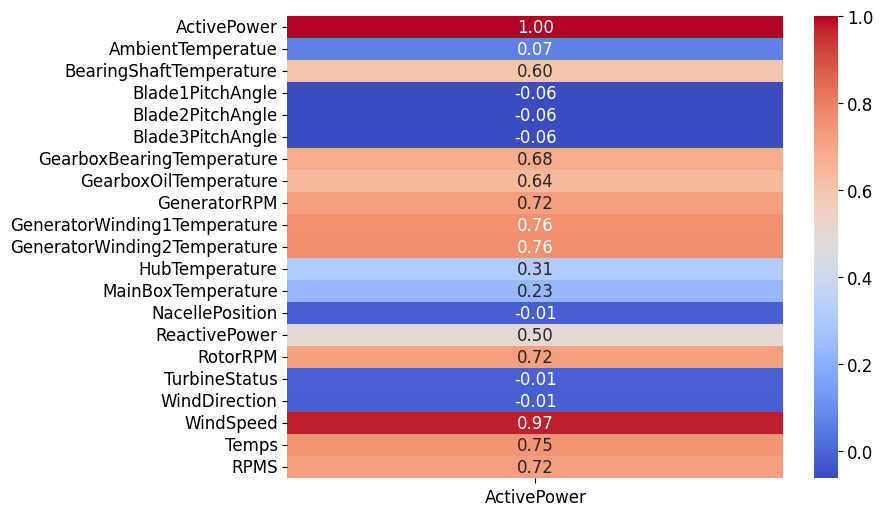

In [59]:
df['Temps'] = (df['GeneratorWinding2Temperature'] + df['GeneratorWinding2Temperature'] + df['GearboxBearingTemperature'] + df['GearboxOilTemperature'])
df['RPMS'] = (df['GeneratorRPM'] + df['RotorRPM'])
corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr[['ActivePower']], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

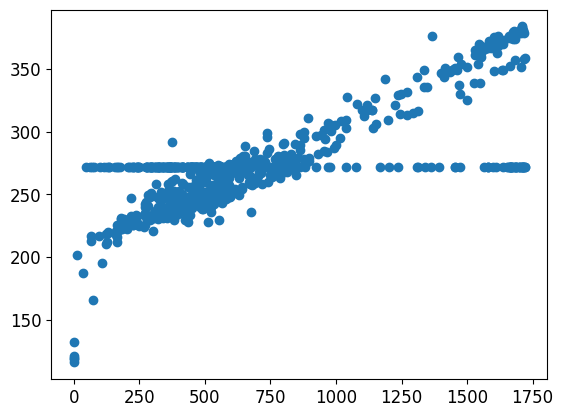

In [60]:
plt.scatter(df['ActivePower'], df['Temps']) #  horizontal line shows the mean impupted values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


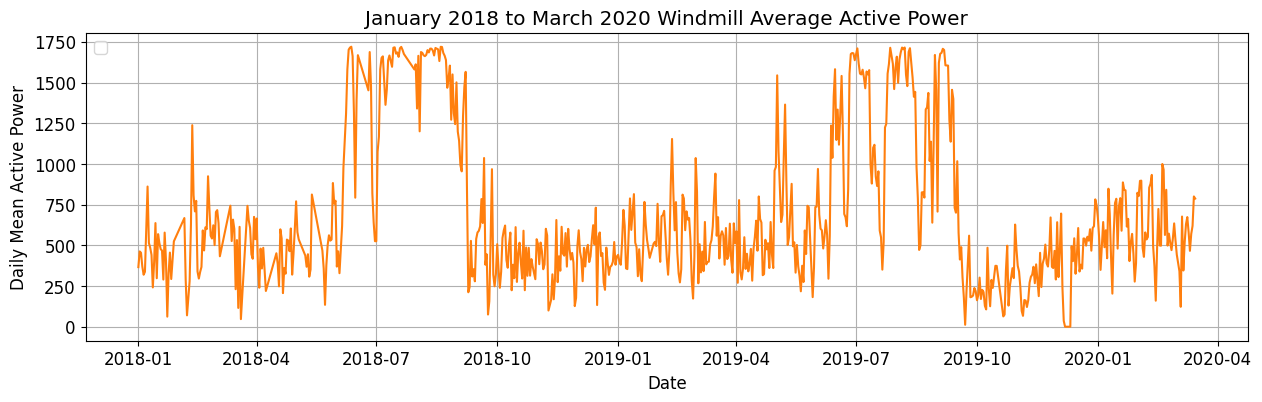

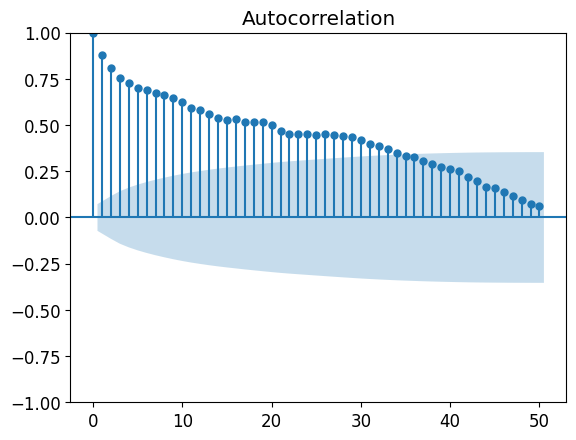

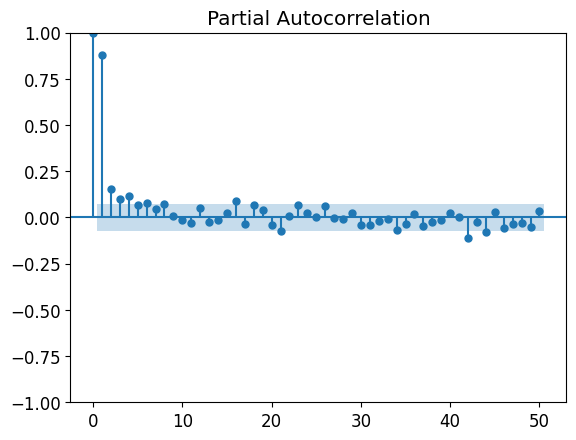


adf test p-value: 0.01792376595212774 ==> stationary


In [61]:
#time series plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 4))

ax.plot(df['ActivePower'], color='tab:orange')#, label='Daily Confirmed Case')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Mean Active Power')
ax.set_title('January 2018 to March 2020 Windmill Average Active Power')
ax.grid(True)
ax.legend(loc='upper left')
plt.show()
# ACF
plot_acf(df['ActivePower'],lags=50)
plt.show()
# PACF
plot_pacf(df['ActivePower'],lags=50)
plt.show()
# Dickey Fuller Test
adf_result = adfuller(df['ActivePower'], autolag="AIC")[1]
if adf_result <= 0.05:
    print(f'\nadf test p-value: {adf_result} ==> stationary')
else:
    print(f'\nadf test p-value: {adf_result} ==> non-stationary')

## SARIMAX

In [62]:
k = 31 #  Forecast length 
exog = ['Temps', 'WindSpeed', 'GeneratorRPM', 'GeneratorWinding1Temperature', 'RotorRPM'] # Exogenous Variables to Include

# variables to be used in training
y = df['ActivePower'][:-k]
X = df[exog][:-k]

testX, testY = df[exog][-k:], df['ActivePower'][-k:]

In [63]:
X.join(y)

,Temps,WindSpeed,GeneratorRPM,GeneratorWinding1Temperature,RotorRPM,ActivePower
Datetime,,,,,,
2018-01-01,272.260329,5.263797,1256.155212,74.618991,11.269820,366.223561
2018-01-02,272.260329,5.390719,1256.155212,74.618991,11.269820,462.550740
2018-01-03,272.260329,5.295225,1256.155212,74.618991,11.269820,454.417752
2018-01-04,272.260329,5.094994,1256.155212,74.618991,11.269820,369.952190
2018-01-05,272.260329,4.915224,1256.155212,74.618991,11.269820,319.446595
...,...,...,...,...,...,...
2020-02-09,279.416475,6.616840,1325.584878,77.886232,11.888835,854.403582
2020-02-10,278.169189,6.820561,1363.836190,77.229596,12.229086,877.905940
2020-02-11,282.027116,7.029250,1401.105941,78.879379,12.562690,932.717865


### With exog

In [82]:
best_trend = (0,0,1)
best_seasonality = (6,0,3,21)
model1 = ARIMA(y, exog=X, order=best_trend, seasonal_order=best_seasonality).fit()
forecast1 = model1.predict(start=len(y), end=len(y)+k-1, exog=testX)
#print(f'SARIMA{best_trend}, {best_seasonality} RMSE: {np.sqrt(np.sum(mean_squared_error(np.array(forecast1), testY)) / testY.shape[0])}')

SARIMA(0, 0, 1), (6, 0, 3, 21) RMSE: 8.436200404288366


In [91]:
print(f'SARIMA{best_trend}, {best_seasonality} RMSE: {np.sqrt(np.sum((np.array(forecast1[-k:]) - testY)**2) / testY.shape[0])}')

SARIMA(0, 0, 1), (6, 0, 3, 21) RMSE: 46.97077596868898


### Without exog

In [83]:
best_trend = (0,0,1)
best_seasonality = (6,0,3,21)
model2 = ARIMA(y, order=best_trend, seasonal_order=best_seasonality).fit()
forecast2 = model2.predict(start=len(y), end=len(y)+k-1)

SARIMA(0, 0, 1), (6, 0, 3, 21) RMSE: 50.50214046150425


In [92]:
print(f'SARIMA{best_trend}, {best_seasonality} RMSE: {np.sqrt(np.sum((np.array(forecast2[-k:]) - testY)**2) / testY.shape[0])}')

SARIMA(0, 0, 1), (6, 0, 3, 21) RMSE: 281.18401790819945


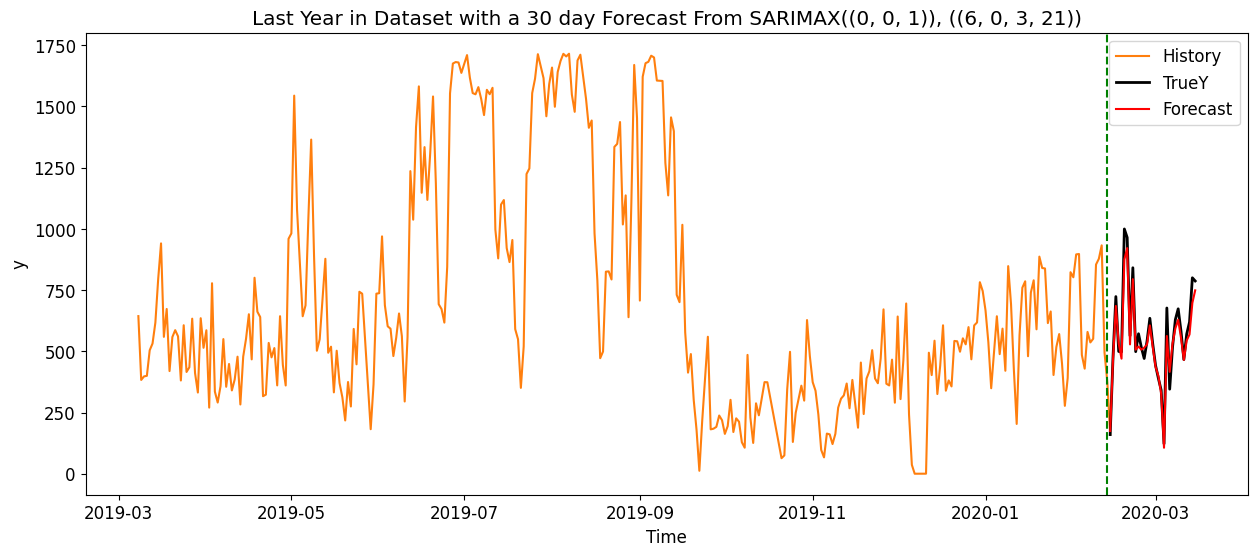

In [84]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))


ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY', linewidth=2)
ax.plot(df.index[-k:], forecast1, color='red', label='Forecast1')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title(f'Last Year in Dataset with a 30 day Forecast From SARIMAX({best_trend}), ({best_seasonality})')
plt.legend()

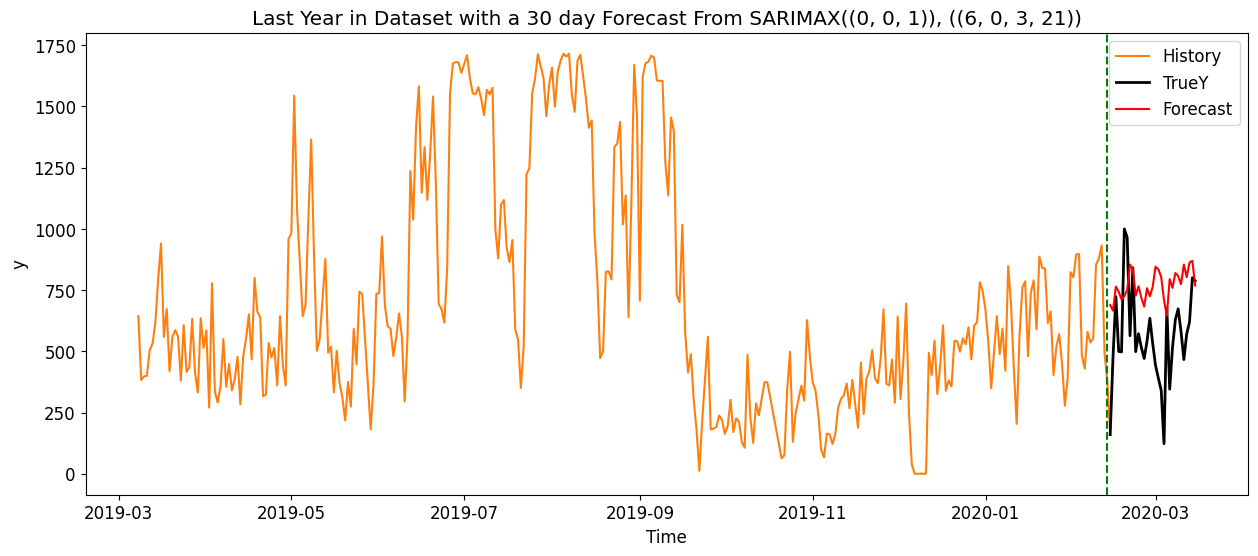

In [85]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))


ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY', linewidth=2)
ax.plot(df.index[-k:], forecast2, color='red', label='Forecast2')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title(f'Last Year in Dataset with a 30 day Forecast From SARIMAX({best_trend}), ({best_seasonality})')
plt.legend()

## ETS

In [50]:
import pandas as pd
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_1 = ExponentialSmoothing(X.WindSpeed, trend="add", seasonal="add", seasonal_periods=21, damped_trend=False).fit()
model_2 = ExponentialSmoothing(X.WindSpeed, trend="add", seasonal="add", seasonal_periods=21, damped_trend=True).fit()
model_3 = ExponentialSmoothing(X.WindSpeed, trend="add", seasonal="mul", seasonal_periods=21, damped_trend=True).fit()
model_4 = ExponentialSmoothing(X.WindSpeed, trend="mul", seasonal="mul", seasonal_periods=21, damped_trend=True).fit()
model_5 = ExponentialSmoothing(X.WindSpeed, trend="mul", seasonal="mul", seasonal_periods=12, damped_trend=False).fit()
model_6 = ExponentialSmoothing(X.WindSpeed, trend="mul", seasonal="add", seasonal_periods=12, damped_trend=True).fit()
model_7 = ExponentialSmoothing(X.WindSpeed, trend="mul", seasonal="add", seasonal_periods=12, damped_trend=False).fit()
model_8 = ExponentialSmoothing(X.WindSpeed, trend="add", seasonal="mul", seasonal_periods=12, damped_trend=False).fit()

In [51]:
pred_1 = pd.DataFrame(model_1.forecast(len(testY)))
pred_2 = pd.DataFrame(model_2.forecast(len(testY)))
pred_3 = pd.DataFrame(model_3.forecast(len(testY)))
pred_4 = pd.DataFrame(model_4.forecast(len(testY)))
pred_5 = pd.DataFrame(model_5.forecast(len(testY)))
pred_6 = pd.DataFrame(model_6.forecast(len(testY)))
pred_7 = pd.DataFrame(model_7.forecast(len(testY)))
pred_8 = pd.DataFrame(model_8.forecast(len(testY)))

In [52]:
print(f'ETS AA RMSE: {np.sum(mean_squared_error(np.array(pred_1), testY)) / testY.shape[0]}')
print(f'ETS AAD RMSE: {np.sum(mean_squared_error(np.array(pred_2), testY)) / testY.shape[0]}')
print(f'ETS AMD RMSE: {np.sum(mean_squared_error(np.array(pred_3), testY)) / testY.shape[0]}')
print(f'ETS MMD RMSE: {np.sum(mean_squared_error(np.array(pred_4), testY)) / testY.shape[0]}')
print(f'ETS MM RMSE: {np.sum(mean_squared_error(np.array(pred_5), testY)) / testY.shape[0]}')
print(f'ETS MAD RMSE: {np.sum(mean_squared_error(np.array(pred_6), testY)) / testY.shape[0]}')
print(f'ETS MA RMSE: {np.sum(mean_squared_error(np.array(pred_7), testY)) / testY.shape[0]}')
print(f'ETS AM RMSE: {np.sum(mean_squared_error(np.array(pred_1), testY)) / testY.shape[0]}')

ETS AA RMSE: 11210.94791122027
ETS AAD RMSE: 11211.340358464337
ETS AMD RMSE: 11208.503819163525
ETS MMD RMSE: 11208.792448689175
ETS MM RMSE: 11230.091944633074
ETS MAD RMSE: 11217.167377421065
ETS MA RMSE: 11234.75432462272
ETS AM RMSE: 11210.94791122027


Plot of forecast for ETS model 1 (the other ETS models look very similar).

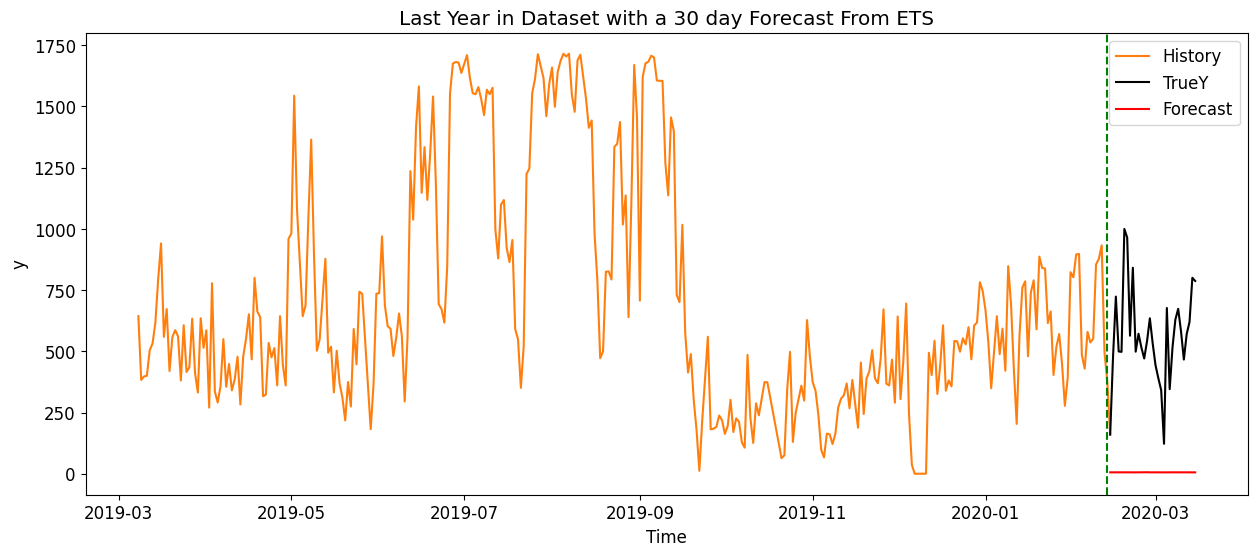

In [55]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index[-365:-k+1], df['ActivePower'][-365:-k+1], color='tab:orange', label='History')

ax.plot(df.index[-k:], df['ActivePower'][-k:], color='black', label='TrueY')
ax.plot(df.index[-k:], pred_1, color='red', label='Forecast')
ax.axvline(x=df.index[-k-1:-k], c='green', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('y')
plt.title('Last Year in Dataset with a 30 day Forecast From ETS')
plt.legend()